<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/Topic_Classifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autokeras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import autokeras as ak

In [3]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train')

# veiw of labels on training set
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

# Preprocessing

In [5]:
# label choosing
categories = ['comp.sys.ibm.pc.hardware',
        'rec.autos',
        'rec.sport.baseball',
        'sci.med',
        'sci.space',
        'talk.politics.mideast',]
# 取得含有指定標籤之資料訓練集,並移除原資料集的標頭,註腳及引言
train = fetch_20newsgroups(subset='train',
              categories=categories,
              remove=('headers', 'footers', 'quotes'))
# 取得含有指定標籤之資料測試集
test = fetch_20newsgroups(subset='test',
              categories=categories,
              remove=('headers', 'footers', 'quotes'))
# convert returned list to ndarray
x_train = np.array(train.data)
y_train = np.array(train.target)
x_test = np.array(test.data)
y_test = np.array(test.target)

print(x_train.shape)
print(x_test.shape)

(3532,)
(2351,)


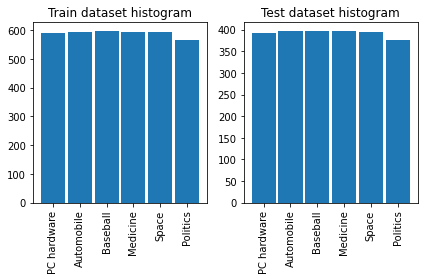

In [7]:
fig = plt.figure()
bin = np.arange(len(categories)+1)
labels = ('PC hardware', 'Automobile', 'Baseball', 'Medicine', 'Space', 'Politics', '') # last empty label for show figure correctly
ax = fig.add_subplot(1,2,1)
ax.set_xticks(bin)
ax.set_xticklabels(labels, rotation=90)
plt.hist(y_train, bins=bin-0.5, rwidth=0.9)
ax.set_title('Train dataset histogram')

ax = fig.add_subplot(1,2,2)
ax.set_xticks(bin)
ax.set_xticklabels(labels, rotation=90)
plt.hist(y_test, bins=bin-0.5, rwidth=0.9)
ax.set_title('Test dataset histogram')

plt.tight_layout()
plt.show()

# Model (CNN)

In [20]:
# from Keras Tuner import Choice class to set Hyperparameters
from keras_tuner.engine.hyperparameters import Choice

# load vector hyperparameters (word2vec TransferLearning)
pretraining = Choice(name='pretraining', values=['word2vec'])

# convolution block 只設1個
num_blocks = Choice(name='num_blocks', values=[1])
callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]

# 為讓文字資料能夠餵CNN,需先以TextToIntSequence將文字轉數列,接著用Embedding轉換成文字向量
# input node
input_node = ak.TextInput()

# output node
output_node = ak.TextToIntSequence(max_tokens=50000)(input_node)

# Embedding
output_node = ak.Embedding(max_features=50000, pretraining=pretraining)(output_node)

# Convolution
output_node = ak.ConvBlock(
    num_blocks=num_blocks, # conv block numbers
    separable=True, # separable conv (Xception)
    max_pooling=True # local max pooling
)(output_node)

# Pooling (Global max pooling)
output_node = ak.SpatialReduction(reduction_type='global_max')(output_node)

# classification
output_node = ak.ClassificationHead()(output_node)

clf = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=15, overwrite=True)
clf.fit(x_train, y_train, callbacks=callbacks)

Trial 15 Complete [00h 06m 43s]
val_loss: 0.47017335891723633

Best val_loss So Far: 0.4249002933502197
Total elapsed time: 00h 06m 43s

Search: Running Trial #16

Hyperparameter    |Value             |Best Value So Far 
text_to_int_seq...|512               |512               
embedding_1/pre...|word2vec          |word2vec          
embedding_1/emb...|128               |128               
embedding_1/dro...|0.25              |0.25              
conv_block_1/ke...|7                 |7                 
conv_block_1/dr...|0.5               |0.5               
conv_block_1/nu...|1                 |1                 
conv_block_1/nu...|1                 |1                 
conv_block_1/fi...|32                |32                
conv_block_1/fi...|32                |32                
classification_...|0.5               |0.5               
optimizer         |adam              |adam              
learning_rate     |2e-05             |0.001             

Epoch 1/1000
89/89 [=================

KeyboardInterrupt: ignored

# Evaluate

In [21]:
clf.evaluate(x_test, y_test)

74/74 [==============================] - 1s 6ms/step - loss: 1.7837 - accuracy: 0.2641


[1.783736228942871, 0.2641429305076599]

In [16]:
predicted = clf.predict(x_test).flatten().astype('uint8')
for i in range(10):
  print('TEXT[')
  # 去除文章頭尾空白,並取前400字
  print(x_test[i].strip()[:400])
  print(f'] PREDICTED: {labels[predicted[i]]}, REAL: {labels[y_test[i]]}')
  print('')

74/74 [==============================] - 0s 5ms/step
TEXT[
. . . David gives good explaination of the deductions from the isotropic,
'edged' distribution, to whit, they are either part of the Universe or
part of the Oort cloud.

Why couldn't they be Earth centred, with the edge occuring at the edge
of the gravisphere? I know there isn't any mechanism for them, but there
isn't a mechanism for the others either.
] PREDICTED: Medicine, REAL: Space

TEXT[
Article #61083 (61123 is last):
From: scholten@epg.nist.gov (Robert Scholten)
Subject: Re: How hot should the cpu be?
Date: Wed Apr 21 19:01:49 1993

The temp on my 486DX2/66 is over 96C (measured with a K-type thermocouple 
and Fluke 55 dig thermometer).  This is an "idle" temp - not doing lots of
bus i/o, not doing floating point, not doing 32-bit protected mode etc.  This
is in a Micron compute
] PREDICTED: PC hardware, REAL: PC hardware

TEXT[
Hi all netters,

  If I upgrade my XT with a 286+ motherboard, will I be able to use the old

In [22]:
labels = ('PC hardware', 'Automobile', 'Baseball', 'Medicine', 'Space', 'Politics')
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted, target_names=labels))

              precision    recall  f1-score   support

 PC hardware       0.53      0.35      0.42       392
  Automobile       0.30      0.41      0.34       396
    Baseball       0.24      0.22      0.23       397
    Medicine       0.19      0.56      0.28       396
       Space       0.50      0.02      0.03       394
    Politics       1.00      0.01      0.02       376

    accuracy                           0.26      2351
   macro avg       0.46      0.26      0.22      2351
weighted avg       0.45      0.26      0.22      2351



# Visualization

In [23]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLast  (None, 1)                0         
 Dim)                                                            
                                                                 
 text_vectorization (TextVec  (None, 64)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 64, 128)           6400000   
                                                                 
 dropout (Dropout)           (None, 64, 128)           0         
                                                                 
 separable_conv1d (Separable  (None, 58, 32)           5024  

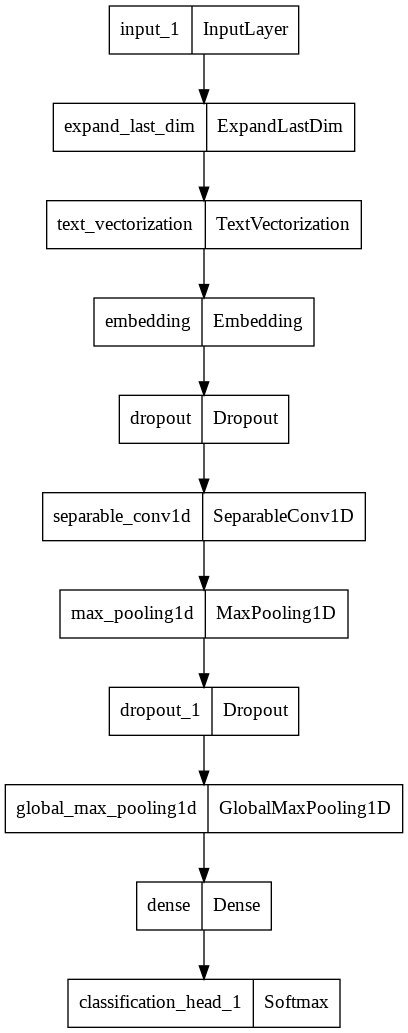

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model)